# Mrtav projekat

## Paketi

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata

### Pomocne fun

In [136]:
def df_info(df):
    print(f"Dataset shape: {df.shape}")
    print(f"Label distribution:\n{df['label'].value_counts()}")
    print(f"Label distribution (percentage):\n{df['label'].value_counts(normalize=True) * 100}")

In [137]:
def get_text_stats(text):
    """Calculate various text statistics"""
    # Count words (simple split on whitespace)
    words = str(text).split()
    word_count = len(words)
    
    # Count characters
    char_count = len(str(text))
    
    # Count sentences (rough approximation)
    sentence_count = len(re.split(r'[.!?]+', str(text))) - 1
    sentence_count = max(1, sentence_count)  # Ensure at least 1 sentence
    
    # Average word length
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    
    # Average sentence length in words
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    return {
        'word_count': word_count,
        'char_count': char_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

In [138]:
def text_len_dist(stats):
    plt.figure(figsize=(12, 6))
    sns.histplot(stats['word_count'], bins=30, kde=True)
    plt.title('Distribution of Text Length (Word Count)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.axvline(stats['word_count'].median(), color='red', linestyle='--', label=f'Median: {stats["word_count"].median():.1f}')
    plt.axvline(stats['word_count'].mean(), color='green', linestyle='--', label=f'Mean: {stats["word_count"].mean():.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [139]:

# Step 1.1: Normalize URLs
def normalize_urls(text):
    """
    Normalize URLs to a standard format
    Options:
    1. Replace all URLs with a token like [URL]
    2. Keep domain only
    3. Remove completely
    """
    # Option 1: Replace URLs with [URL] token
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('[URL]', text)
    
    # Option 2: Keep domain name only (uncomment if preferred)
    # def replace_with_domain(match):
    #     url = match.group(0)
    #     domain_match = re.search(r'(?:https?://)?(?:www\.)?([^/]+)', url)
    #     if domain_match:
    #         return f"[{domain_match.group(1)}]"
    #     return "[URL]"
    # return url_pattern.sub(replace_with_domain, text)
    
    # Option 3: Remove URLs completely (uncomment if preferred)
    # return url_pattern.sub('', text)

In [140]:

# Step 1.2: Standardize different quote types
def standardize_quotes(text):
    """
    Standardize all quotation marks to straight double quotes (")
    """
    # List of quote characters to normalize
    quotes = ["'", "'", '`', '´', '"', '"', '„', '‟', '«', '»', '‹', '›', '“', '”']
    
    # Replace all opening/closing quotes with standard double quotes
    for quote in quotes:
        text = text.replace(quote, '"')
    
    # Replace single quotes with standard single quote
    text = text.replace(''', "'")
    text = text.replace(''', "'")
    
    return text

In [141]:
def normalize_punctuation(text):
    """
    Normalize punctuation marks and spacing around them
    """
    # Normalize unicode punctuation to ASCII equivalents where possible
    text = unicodedata.normalize('NFKD', text)
    
    # Standardize dashes
    text = re.sub(r'—|–|‐|‒|―|⁃', '-', text)
    
    return text

In [142]:

def lowercase_text(text):
    return text.lower()

def remove_extra_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

In [143]:
def preprocess_text(text):    
    # Apply each preprocessing step
    text = normalize_urls(text)
    text = standardize_quotes(text)
    text = normalize_punctuation(text)
    text = lowercase_text(text)
    text = remove_extra_whitespace(text)
    
    return text

## Datasetovi

### LADDER

In [144]:
ladder_nesta_dev = pd.read_csv('LADDER_dataset/dev.csv', sep='\t')
ladder_train = pd.read_csv('LADDER_dataset/train.csv', sep='\t')
ladder_test = pd.read_csv('LADDER_dataset/test.csv', sep='\t')

In [145]:
merged_ladder = pd.concat([ladder_train, ladder_test, ladder_nesta_dev], ignore_index=True)

In [146]:
df_info(merged_ladder)

Dataset shape: (3444, 2)
Label distribution:
label
1    1722
0    1722
Name: count, dtype: int64
Label distribution (percentage):
label
1    50.0
0    50.0
Name: proportion, dtype: float64


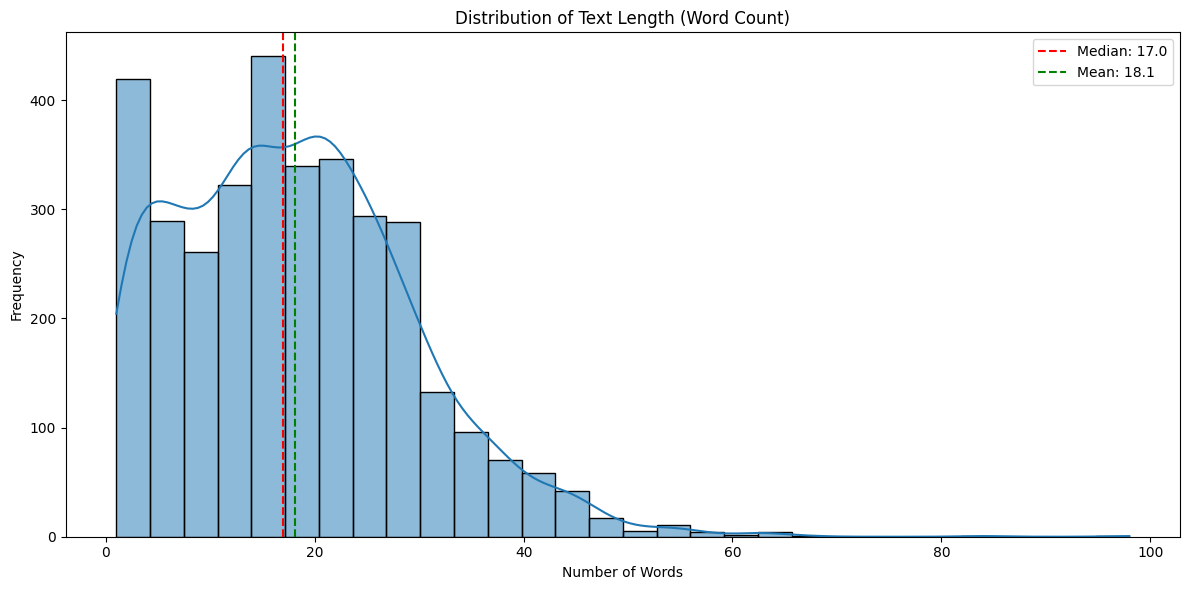

In [147]:
ladder_stats = pd.DataFrame(merged_ladder['text'].apply(get_text_stats).tolist())
text_len_dist(ladder_stats)

In [148]:
merged_ladder['text'] = merged_ladder['text'].apply(preprocess_text)

merged_ladder.to_csv('PerfectlyBalancedAsAllThingsShouldBe/ladder_preprocessed.csv', index=False)

### Zerinino

In [149]:
zerinino = pd.read_csv('Zerinino/social_media.csv')
zerinino['label'] = 0
zerinino = zerinino.rename(columns={'message': 'text'}) 


In [150]:
df_info(zerinino)

Dataset shape: (63018, 2)
Label distribution:
label
0    63018
Name: count, dtype: int64
Label distribution (percentage):
label
0    100.0
Name: proportion, dtype: float64


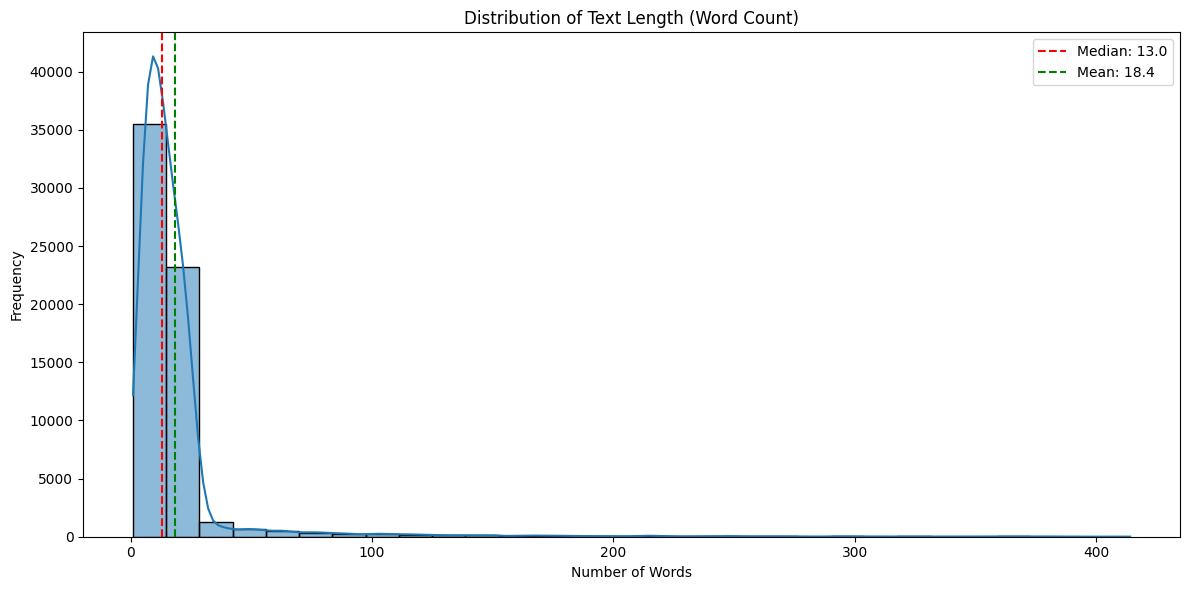

In [151]:
zerinino_stats = pd.DataFrame(zerinino['text'].apply(get_text_stats).tolist())
text_len_dist(zerinino_stats)

Dataset shape: (1576, 2)
Label distribution:
label
0    1576
Name: count, dtype: int64
Label distribution (percentage):
label
0    100.0
Name: proportion, dtype: float64


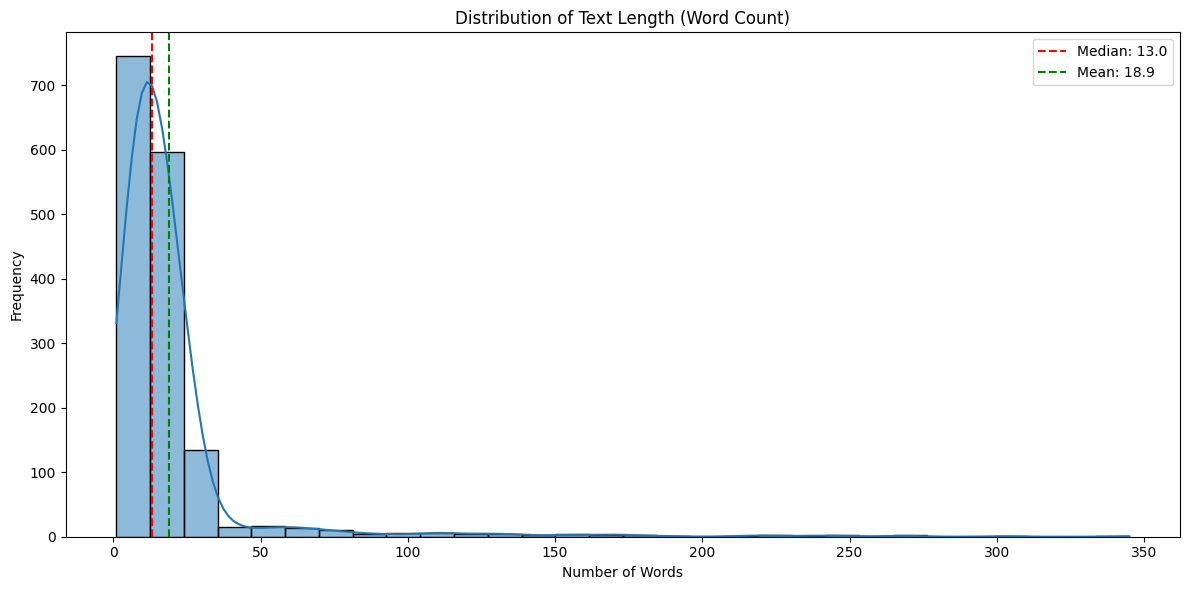

In [152]:
zerinino_skraceno = zerinino.iloc[::40]
df_info(zerinino_skraceno)
stats = pd.DataFrame(zerinino_skraceno['text'].apply(get_text_stats).tolist())
text_len_dist(stats)

In [153]:
df = pd.concat([merged_ladder, zerinino_skraceno], ignore_index=True)

Dataset shape: (5020, 2)
Label distribution:
label
0    3298
1    1722
Name: count, dtype: int64
Label distribution (percentage):
label
0    65.697211
1    34.302789
Name: proportion, dtype: float64


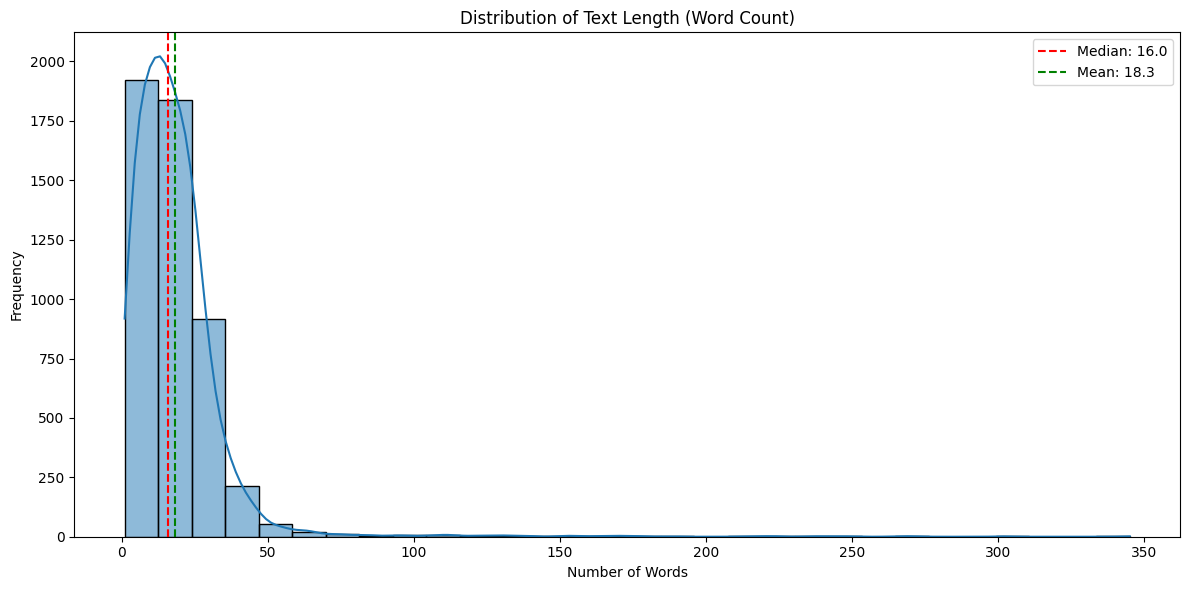

In [154]:
df_info(df)
stats = pd.DataFrame(df['text'].apply(get_text_stats).tolist())
text_len_dist(stats)

In [155]:
df.to_csv('NebalansiranoFuj/ladder_zerinino.csv', index=False)

df.iloc[241]

text     "hi", "ask" - enable and disable mobile internet;
label                                                    1
Name: 241, dtype: object

## Preprocesing

## BERT

## LSTM

## Random nesta